### Generacion de linea base
En esta seccion se intentará reproducir los resultados de otro trabajo, especìficamente: Jin et al., 2015

In [1]:
# Importar los datos en un dataframe
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', 500)
data = pd.read_csv('loan.csv',low_memory=False)
data.head(3)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1077501,1296599,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,Dec-2011,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,860xx,AZ,27.65,0.0,Jan-1985,1.0,NaN,NaN,3.0,0.0,13648.0,83.7,9.0,f,0.0,0.0,5861.071414,5831.78,5000.00,861.07,0.0,0.00,0.00,Jan-2015,171.62,NaN,Jan-2016,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,1314167,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Dec-2011,Charged Off,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I plan to use t...,car,bike,309xx,GA,1.00,0.0,Apr-1999,5.0,NaN,NaN,3.0,0.0,1687.0,9.4,4.0,f,0.0,0.0,1008.710000,1008.71,456.46,435.17,0.0,117.08,1.11,Apr-2013,119.66,NaN,Sep-2013,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,1313524,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,C5,NaN,10+ years,RENT,12252.0,Not Verified,Dec-2011,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,NaN,small_business,real estate business,606xx,IL,8.72,0.0,Nov-2001,2.0,NaN,NaN,2.0,0.0,2956.0,98.5,10.0,f,0.0,0.0,3003.653644,3003.65,2400.00,603.65,0.0,0.00,0.00,Jun-2014,649.91,NaN,Jan-2016,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [2]:
from datetime import datetime
def to_date(date_str):
    return datetime.strptime(date_str,'%Y%m%d')
    
# Se filtran los datos de julio 2007 a diciembre 2011
print(f'Data original:{data.count()[0]}')
print('Filtrando datos de jul-07 a dic-11')
data['issued'] = pd.to_datetime(data.issue_d)
data2 = data.where(lambda x: x.issued>=to_date('20070701')).where(lambda x: x.issued<=to_date('20111231'))
print(f'Data de jul-07 a dic-11: {data2.count()[0]}')

# Se filtran los registros inconsistentes o no aplicables para analisis
# Current -> No aplicable porque son préstamos dentro de su periodo de pago.
# Does not meet the credit policy (...) -> Inconsistente. No se sabe si es un error o un valor correcto.
# Issued -> No aplicable porque son créditos recién emitidos.
# In grace period -> No aplicable porque son créditos en periodo de gracia.
print('Eliminando registros inconsistentes o no aplicables para analisis.')
estados_eliminar = {'In Grace Period','Current','Does not meet the credit policy. Status:Fully Paid', 'Does not meet the credit policy. Status:Charged Off', 'Issued'}
for estado in estados_eliminar:
    data2.drop(data2[data2.loan_status==estado].index,inplace=True)
    print(f'Eliminado {estado}. Quedan: {data2.count()[0]}')
    
# Se crean las clases
# 1: Default|Charged Off
# 2: Late (31-120 days)|Late (16-30 days)
# 3: Fully Paid
data2['class'] = 3*(data2.loan_status=='Fully Paid') + 2*((data2.loan_status=='Late (16-30 days)') | (data2.loan_status=='Late (31-120 days)')) + 1*((data2.loan_status=='Default') | (data2.loan_status=='Charged Off'))
print('Se crearon las clases.')

Data original:887379
Filtrando datos de jul-07 a dic-11
Data de jul-07 a dic-11: 42511
Eliminando registros inconsistentes o no aplicables para analisis.
Eliminado Issued. Quedan: 42511
Eliminado Current. Quedan: 40551
Eliminado Does not meet the credit policy. Status:Charged Off. Quedan: 39793
Eliminado Does not meet the credit policy. Status:Fully Paid. Quedan: 37825
Eliminado In Grace Period. Quedan: 37797
Se crearon las clases.


In [3]:
# Explorar la distribución de la etiqueta de clase
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings('ignore',category=FutureWarning)
    #aggregation_function = {'id':{'cuenta':'count'},'loan_amnt':{'suma':'sum','contador':lambda x: int(sum(x)/data2.loc[x.index].loan_amnt.sum())}}
    aggregation_function = {'id':{'cuenta':'count'},'loan_amnt':{'suma':'sum'}}
    data_res=data2.groupby(['class','loan_status'],as_index=True).agg(aggregation_function)
data_res['id','porcentaje_cuenta'] = round(data_res['id','cuenta']/data_res['id'].sum()[0]*100,2)
data_res['loan_amnt','porcentaje_monto'] = round(data_res['loan_amnt','suma']/data_res['loan_amnt'].sum()[0]*100,2)
data_res.sort_index(axis=1)

id                          loan_amnt  \
                         cuenta porcentaje_cuenta porcentaje_monto   
class loan_status                                                    
1     Charged Off          5574             14.75            16.21   
      Default                 9              0.02             0.03   
2     Late (16-30 days)      13              0.03             0.05   
      Late (31-120 days)     51              0.13             0.22   
3     Fully Paid          32150             85.06            83.50   

                                       
                                 suma  
class loan_status                      
1     Charged Off          67205600.0  
      Default                122000.0  
2     Late (16-30 days)      197600.0  
      Late (31-120 days)     903125.0  
3     Fully Paid          346213675.0

In [4]:
# Balanceo tomando 7000 registros de tipo Fully Paid y explorar el resultado final
n_rows_to_delete = data2[data2['class']==3].count()[0]-7000
data3 = data2.drop(data2[data2['class']==3].sample(n=n_rows_to_delete,random_state=40).index)
with warnings.catch_warnings():
    warnings.filterwarnings('ignore',category=FutureWarning)
    aggregation_function = {'id':{'cuenta':'count'},'loan_amnt':{'suma':'sum'}}
    data_show=data3.groupby(['class','loan_status'],as_index=True).agg(aggregation_function)
data_show['id','porcentaje_cuenta'] = round(data_show['id','cuenta']/data_show['id'].sum()[0]*100,2)
data_show['loan_amnt','porcentaje_monto'] = round(data_show['loan_amnt','suma']/data_show['loan_amnt'].sum()[0]*100,2)
data_show.sort_index(axis=1)

id                          loan_amnt            
                         cuenta porcentaje_cuenta porcentaje_monto        suma
class loan_status                                                             
1     Charged Off          5574             44.07            46.61  67205600.0
      Default                 9              0.07             0.08    122000.0
2     Late (16-30 days)      13              0.10             0.14    197600.0
      Late (31-120 days)     51              0.40             0.63    903125.0
3     Fully Paid           7000             55.35            52.54  75767500.0

In [5]:
# Explorar el proposito de las deudas
with warnings.catch_warnings():
    warnings.filterwarnings('ignore',category=FutureWarning)
    aggregation_function = {'id':{'cuenta':'count'},'loan_amnt':{'suma':'sum'}}
    data_show=data3.groupby('purpose',as_index=True).agg(aggregation_function)
data_show['id','porcentaje_cuenta'] = round(data_show['id','cuenta']/data_show['id'].sum()[0]*100,2)
data_show['loan_amnt','porcentaje_monto'] = round(data_show['loan_amnt','suma']/data_show['loan_amnt'].sum()[0]*100,2)
data_show.sort_index(axis=1).sort_values(by=[('id','porcentaje_cuenta')],ascending=False)

id                          loan_amnt            
                   cuenta porcentaje_cuenta porcentaje_monto        suma
purpose                                                                 
debt_consolidation   5974             47.24            53.04  76488600.0
credit_card          1515             11.98            12.67  18266525.0
other                1322             10.45             7.64  11012675.0
home_improvement      920              7.27             7.22  10404650.0
small_business        737              5.83             7.13  10285225.0
major_purchase        605              4.78             3.59   5173075.0
car                   450              3.56             2.17   3132175.0
wedding               270              2.13             1.93   2789600.0
medical               236              1.87             1.34   1938650.0
moving                199              1.57             0.90   1297650.0
vacation              144              1.14             0.58    830275.0
house                 123              0.97             1.02   1475450.0
educational           115              0.91             0.57    821625.0
renewable_energy       37              0.29             0.19    279650.0

In [129]:
# Eliminar columnas de id
id_lst=list(map(lambda x: 'id' in x,data3.columns))
id_column_name_lst = list(data3.columns[id_lst])
print(f'Numero de columnas original: {len(data3.columns.tolist())}')
data_clear = data3.drop(columns=id_column_name_lst, axis=1)
print(f'Numero de columnas filtrado: {len(data_clear.columns.tolist())}')

# Se eliminan las columnas con mas de 99% de sus valores perdidos (nulos)
cols_elim = [x for x in data_clear.columns if data_clear[x].isnull().sum()/data_clear.count().max()>=0.99]
data_clear = data_clear.drop(columns=cols_elim,axis=1)
print(f'Cantidad de columnas originales: {data.shape[1]}')
print(f'Cantidad de columnas a eliminar: {len(cols_elim)}')
print(f'Cantidad de columnas finales: {data_clear.shape[1]}')

# Codificar campos categóricos
print(f'Codificando campos categoricos')
cat_cols = data_clear.select_dtypes(include='object').columns.tolist()
cat_cols.remove('loan_status')
cat_dict = dict()
for col in cat_cols:
    data_clear[col] = data_clear[col].astype('category')
    cat_dict[col] = {i+1:c for i,c in enumerate(data_clear[col].cat.categories)}
    data_clear[col] = data_clear[col].cat.codes+1
    
# Llenar valores vacios con mediana
print(f'Llenando los vacios con el valor de la mediana.')
data_clear_f = data_clear.fillna(value=data_clear.median())

Numero de columnas original: 76
Numero de columnas filtrado: 74
Cantidad de columnas originales: 75
Cantidad de columnas a eliminar: 24
Cantidad de columnas finales: 50
Codificando campos categoricos
Llenando los vacios con el valor de la mediana.


In [146]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X = data_clear_f[data_clear_f.drop(columns=['loan_status','class','issued','desc',
                                            'last_credit_pull_d','issue_d','last_pymnt_d',
                                            'zip_code','addr_state','url'],axis=1).columns.tolist()]
y = data_clear_f['class']

X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.10, random_state=40)
print(f'El set de entrenamiento/validacion tiene {len(X_trainval)} muestras.')
print(f'El set de pruebas tiene {len(X_test)} muestras.')

#forest = ExtraTreesClassifier(n_estimators=250,random_state=0)
print('Ejecutando Random Forest...')
forest =  RandomForestClassifier(random_state=20,n_estimators=50,criterion='gini',n_jobs=5,bootstrap=False)
forest.fit(X_trainval,y_trainval)
feature_importances=sorted(zip(map(lambda x: round(x,4),forest.feature_importances_),X_trainval.columns.tolist()),reverse=True)
print('Lista de importancia de atributos:')
print(feature_importances)

El set de entrenamiento/validacion tiene 771763 muestras.
El set de pruebas tiene 85752 muestras.
Ejecutando Random Forest...
Lista de importancia de atributos:
[(0.1069, 'term'), (0.0922, 'sub_grade'), (0.0908, 'application_type'), (0.0826, 'purpose'), (0.0749, 'home_ownership'), (0.0694, 'recoveries'), (0.062, 'total_rec_prncp'), (0.0584, 'emp_length'), (0.0527, 'pymnt_plan'), (0.0451, 'verification_status'), (0.0449, 'initial_list_status'), (0.0385, 'collection_recovery_fee'), (0.0225, 'last_pymnt_amnt'), (0.017, 'grade'), (0.0158, 'total_pymnt_inv'), (0.0157, 'earliest_cr_line'), (0.0156, 'title'), (0.0155, 'total_pymnt'), (0.0145, 'emp_title'), (0.0138, 'installment'), (0.0107, 'int_rate'), (0.0103, 'funded_amnt'), (0.0091, 'loan_amnt'), (0.0076, 'funded_amnt_inv'), (0.0039, 'total_rec_int'), (0.0019, 'out_prncp_inv'), (0.0017, 'out_prncp'), (0.0011, 'total_rec_late_fee'), (0.0009, 'revol_util'), (0.0008, 'open_acc'), (0.0008, 'dti'), (0.0007, 'revol_bal'), (0.0006, 'total_acc'), 

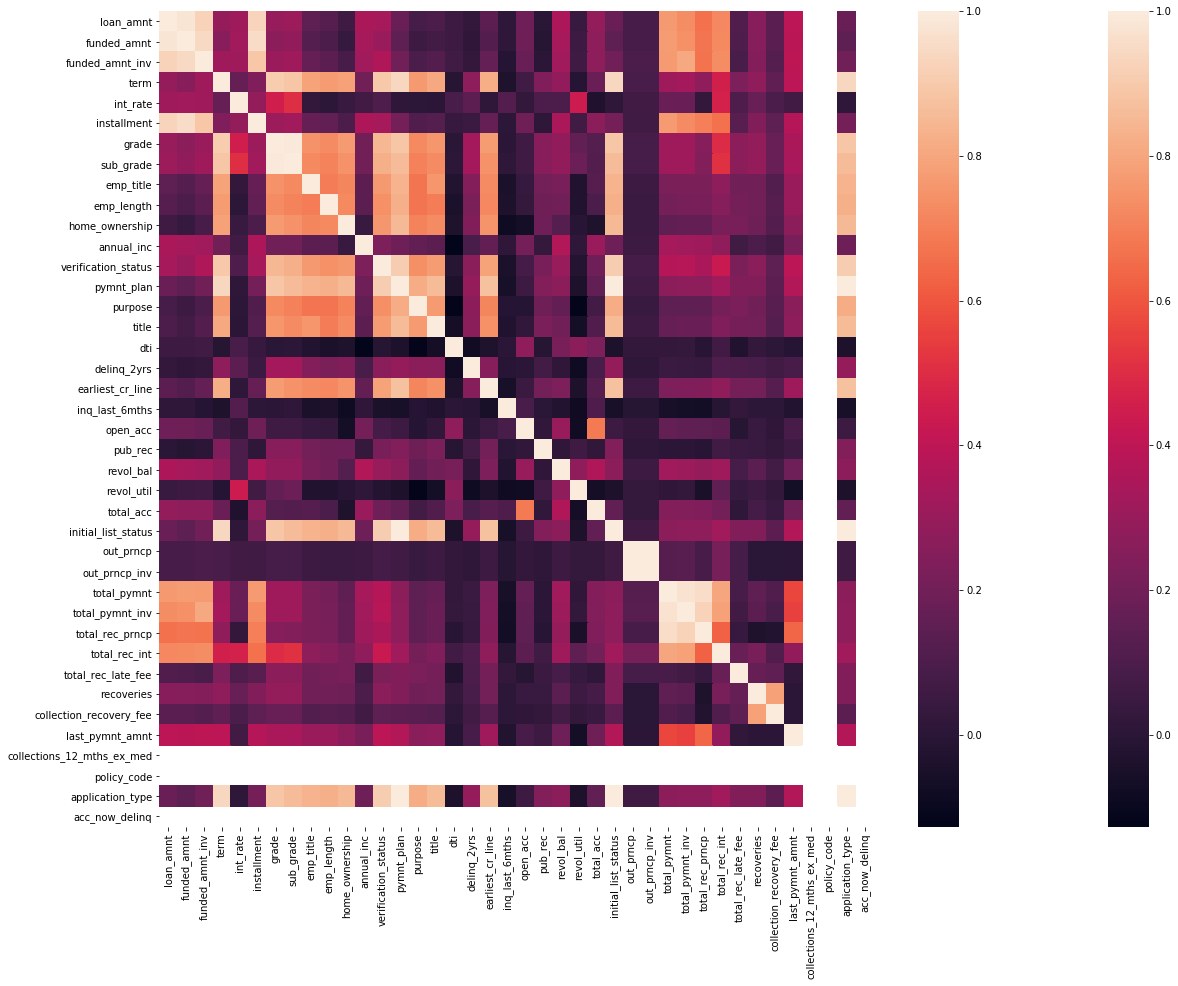

In [147]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.subplots(figsize=(20,15))
sns.heatmap(corr)
corr = X_trainval.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In [215]:
selected_columns = ['term','loan_amnt','revol_util','grade','annual_inc','purpose','pymnt_plan','revol_bal','dti']
data_set_paper = X_trainval[selected_columns] 

In [208]:
# Fuente: documentacion Scikit-learn: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html
# https://stackoverflow.com/questions/45115964/separate-pandas-dataframe-using-sklearns-kfold
from sklearn.model_selection import KFold
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

def f_first(x_lst):
    return x_lst[0]

kf = KFold(n_splits=10,shuffle=True)
classifiers_lst = []
scores_lst = []
print('Ejecutando validacion cruzada')
for train_index, test_index in kf.split(data_set_paper):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_val = data_set_paper.iloc[train_index], data_set_paper.iloc[test_index]
    y_train, y_val = y_trainval.iloc[train_index], y_trainval.iloc[test_index]
    CART = tree.DecisionTreeClassifier()
    CART = CART.fit(X_train,y_train)
    classifiers_lst.append(CART)
    y_pred = CART.predict(X_val)
    score = accuracy_score(y_val, y_pred)
    scores_lst.append(score)
#avg_score = cross_val_score(tree.DecisionTreeClassifier(),data_set_paper,y_trainval,cv=10).mean()
avg_score = np.mean(scores_lst)
print(f'Accuracy promedio = {avg_score}')
best_class = sorted(zip(scores_lst,classifiers_lst),key=f_first,reverse=True)[0]
print('Mejor clasificador encontrado:')
print(best_class)
print('Probando el mejor clasificador con el set de prueba...')
y_test_pred = best_class[1].predict(X_test)
test_score = accuracy_score(y_test,y_test_pred)
print(f'El accuracy con el set de prueba es {round(test_score,4)}')

Ejecutando validacion cruzada
Accuracy promedio = 0.9935757478035516
Mejor clasificador encontrado:
(0.9938194021534913, DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'))
Probando el mejor clasificador con el set de prueba...
El accuracy con el set de prueba es 0.9993


In [212]:
# Multi-layer perceptron (MLP)
# http://scikit-learn.org/stable/modules/neural_networks_supervised.html

from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPClassifier

kf = KFold(n_splits=10,shuffle=True)
classifiers_lst = []
scores_lst = []
print('Ejecutando validacion cruzada')
for train_index, test_index in kf.split(data_set_paper):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_val = data_set_paper.iloc[train_index], data_set_paper.iloc[test_index]
    y_train, y_val = y_trainval.iloc[train_index], y_trainval.iloc[test_index]
    print("Entrenando clasificador...")
    MLP = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
    MLP = MLP.fit(X_train,y_train)
    classifiers_lst.append(MLP)
    y_pred = MLP.predict(X_val)
    score = accuracy_score(y_val, y_pred)
    print(f'Score: {score}')
    scores_lst.append(score)
#avg_score = cross_val_score(tree.DecisionTreeClassifier(),data_set_paper,y_trainval,cv=10).mean()
avg_score = np.mean(scores_lst)
print(f'Accuracy promedio = {avg_score}')
best_class = sorted(zip(scores_lst,classifiers_lst),key=f_first,reverse=True)[0]
print('Mejor clasificador encontrado:')
print(best_class)
print('Probando el mejor clasificador con el set de prueba...')
y_test_pred = best_class[1].predict(X_test)
test_score = accuracy_score(y_test,y_test_pred)
print(f'El accuracy con el set de prueba es {round(test_score,4)}')

Ejecutando validacion cruzada
TRAIN: [     0      1      2 ... 771760 771761 771762] TEST: [     3     18     30 ... 771744 771754 771756]
Entrenando clasificador...
Score: 0.9849566580717053
TRAIN: [     0      1      2 ... 771759 771760 771762] TEST: [    11     23     35 ... 771755 771757 771761]
Entrenando clasificador...
Score: 0.9855786050248131
TRAIN: [     0      1      2 ... 771760 771761 771762] TEST: [     6     13     33 ... 771717 771723 771753]
Entrenando clasificador...
Score: 0.9848141285616181
TRAIN: [     0      1      2 ... 771760 771761 771762] TEST: [    20     28     47 ... 771742 771749 771758]
Entrenando clasificador...
Score: 0.9855784181610864
TRAIN: [     1      3      4 ... 771758 771761 771762] TEST: [     0      2     21 ... 771743 771759 771760]
Entrenando clasificador...
Score: 0.9853840572198611
TRAIN: [     0      1      2 ... 771760 771761 771762] TEST: [     4      9     12 ... 771739 771741 771746]
Entrenando clasificador...
Score: 0.985980097439618

In [216]:
# Support Vector Machine (SVM)
# http://scikit-learn.org/stable/modules/svm.html

from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn import svm

kf = KFold(n_splits=10,shuffle=True)
classifiers_lst = []
scores_lst = []
print('Ejecutando validacion cruzada')
for train_index, test_index in kf.split(data_set_paper):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_val = data_set_paper.iloc[train_index], data_set_paper.iloc[test_index]
    y_train, y_val = y_trainval.iloc[train_index], y_trainval.iloc[test_index]
    print("Entrenando clasificador...")
    SVC = svm.SVC()
    SVC = SVC.fit(X_train,y_train)
    classifiers_lst.append(SVC)
    y_pred = SVC.predict(X_val)
    score = accuracy_score(y_val, y_pred)
    print(f'Score: {score}')
    scores_lst.append(score)
#avg_score = cross_val_score(tree.DecisionTreeClassifier(),data_set_paper,y_trainval,cv=10).mean()
avg_score = np.mean(scores_lst)
print(f'Accuracy promedio = {avg_score}')
best_class = sorted(zip(scores_lst,classifiers_lst),key=f_first,reverse=True)[0]
print('Mejor clasificador encontrado:')
print(best_class)
print('Probando el mejor clasificador con el set de prueba...')
y_test_pred = best_class[1].predict(X_test)
test_score = accuracy_score(y_test,y_test_pred)
print(f'El accuracy con el set de prueba es {round(test_score,4)}')

Ejecutando validacion cruzada
TRAIN: [     0      1      2 ... 771760 771761 771762] TEST: [     5     20     52 ... 771735 771739 771742]
Entrenando clasificador...
Score: 0.9929642250929681
TRAIN: [     0      1      2 ... 771760 771761 771762] TEST: [    17     21     22 ... 771743 771747 771749]
Entrenando clasificador...
Score: 0.9936898298715938
TRAIN: [     1      2      3 ... 771759 771761 771762] TEST: [     0     15     18 ... 771741 771758 771760]
Entrenando clasificador...
Score: 0.9936768726434041
TRAIN: [     0      2      3 ... 771760 771761 771762] TEST: [     1      6     11 ... 771712 771734 771752]
Entrenando clasificador...
Score: 0.9936897481082202
TRAIN: [     0      1      3 ... 771760 771761 771762] TEST: [     2      8     13 ... 771738 771745 771756]
Entrenando clasificador...
Score: 0.9933787706022598
TRAIN: [     0      1      2 ... 771760 771761 771762] TEST: [     3      9     32 ... 771729 771732 771744]
Entrenando clasificador...
Score: 0.993391727998341